
=== Episode 1 ===
Initial Batteries:
MDs: [3960 4571 3622]
ESs: [15474 18260]
Task 1 (279MB) - Device: MD1
  Energy used: 334.8mAh
  MD1 battery: 4236.0mAh
Task 2 (298MB) - Device: MD2
  Energy used: 136.3mAh
  MD2 battery: 3485.0mAh
Task 3 (359MB) - Device: ES0
  Energy used: 176.8mAh
  MD1 battery: 4190.0mAh
  ES0 battery: 15342.0mAh
Task 4 (137MB) - Device: MD0
  Energy used: 64.8mAh
  MD0 battery: 3895.0mAh
Task 5 (330MB) - Device: ES0
  Energy used: 165.8mAh
  MD2 battery: 3440.0mAh
  ES0 battery: 15221.0mAh
Task 6 (203MB) - Device: MD0
  Energy used: 96.1mAh
  MD0 battery: 3798.0mAh
Task 7 (491MB) - Device: MD2
  Energy used: 224.6mAh
  MD2 battery: 3215.0mAh
Task 8 (439MB) - Device: MD1
  Energy used: 526.8mAh
  MD1 battery: 3663.0mAh
Task 9 (464MB) - Device: ES1
  Energy used: 226.5mAh
  MD0 battery: 3708.0mAh
  ES1 battery: 18122.0mAh
Task 10 (433MB) - Device: MD2
  Energy used: 198.1mAh
  MD2 battery: 3016.0mAh

Episode Summary:
Completed tasks: 10/10
Total energy consumed: 

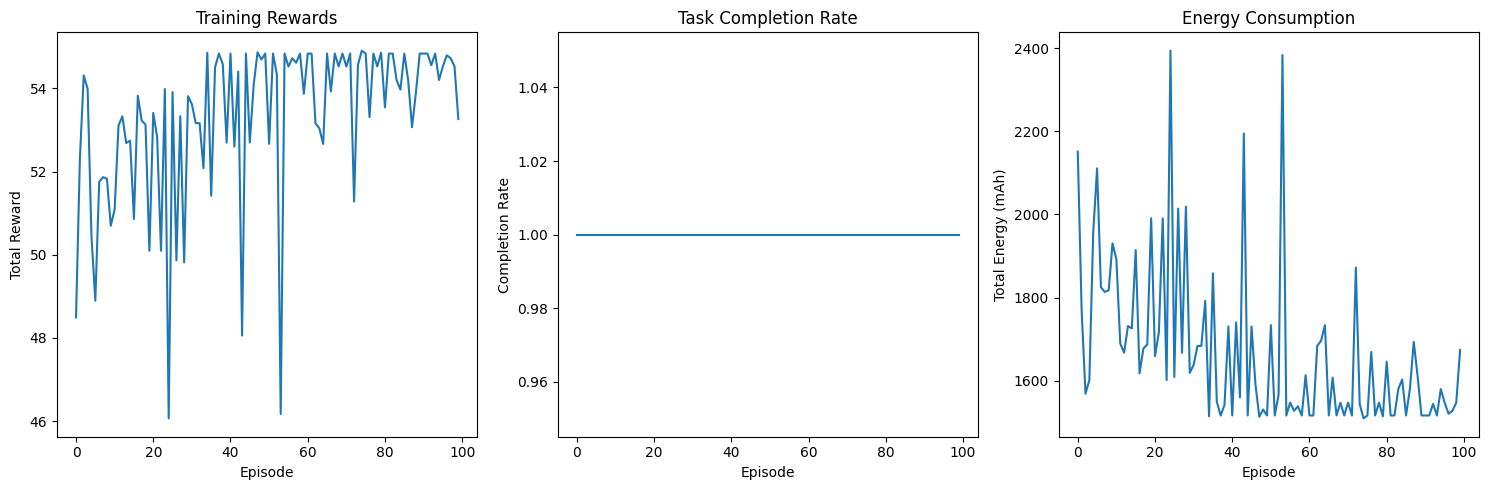

In [2]:
import numpy as np
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

# -------------------------------
# Prioritized Replay Buffer (Fixed)
# -------------------------------
class PrioritizedReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.priorities = np.zeros(capacity)
        self.pos = 0
        self.max_priority = 1.0

    def add(self, experience):
        if len(self.buffer) < self.capacity:
            self.buffer.append(experience)
        else:
            self.buffer[self.pos] = experience
        self.priorities[self.pos] = self.max_priority
        self.pos = (self.pos + 1) % self.capacity

    def sample(self, batch_size, alpha=0.6):
        priorities = self.priorities[:len(self.buffer)] ** alpha
        probs = priorities / priorities.sum()
        indices = np.random.choice(len(self.buffer), batch_size, p=probs)
        samples = [self.buffer[idx] for idx in indices]
        weights = (len(self.buffer) * probs[indices]) ** (-0.5)
        weights /= weights.max()
        return samples, indices, np.array(weights, dtype=np.float32)

    def update_priorities(self, indices, priorities):
        for idx, priority in zip(indices, priorities):
            self.priorities[idx] = priority
        self.max_priority = max(self.max_priority, np.max(priorities))

# -------------------------------------------
# Mobile Edge Computing Environment (Updated)
# -------------------------------------------
class MECEnvironment:
    def __init__(self, num_md=3, num_es=2, num_tasks=10):
        self.num_md = num_md
        self.num_es = num_es
        self.num_tasks = num_tasks
        
        # Mobile Devices (MD) parameters
        self.md_compute = np.random.uniform(1.0, 3.0, num_md)        # GHz
        self.md_battery = np.random.randint(3000, 5001, num_md)      # mAh
        self.md_energy_local = np.random.uniform(1000, 3000, num_md) # mA/s (processing)
        self.md_energy_tx = np.random.uniform(0.1, 0.3, num_md)      # mAh per MB (transmission)
        
        # Edge Servers (ES) parameters
        self.es_compute = np.random.uniform(3.0, 5.0, num_es)        # GHz
        self.es_battery = np.random.randint(10000, 20001, num_es)    # mAh
        self.es_energy_process = np.random.uniform(500, 1500, num_es) # mA/s (processing)
        
        # Task parameters
        self.task_requirements = np.random.randint(100, 501, num_tasks)  # MB
        self.task_to_md = np.random.randint(0, num_md, num_tasks)  # Assign tasks to MDs
        
        self.reset()

    def reset(self):
        # Reset batteries to initial values
        self.md_battery = np.random.randint(3000, 5001, self.num_md)
        self.es_battery = np.random.randint(10000, 20001, self.num_es)
        
        self.current_task = 0
        self.completed_tasks = 0
        self.total_energy = 0
        self.violations = 0
        return self._get_state()

    def _get_state(self):
        if self.current_task >= self.num_tasks:
            return np.zeros(self.state_size)
        
        md_idx = self.task_to_md[self.current_task]
        task_size = self.task_requirements[self.current_task]
        
        # Normalize values
        state = [
            self.md_battery[md_idx] / 5000,
            self.md_compute[md_idx] / 3.0,
            task_size / 500,
            self.md_energy_local[md_idx] / 3000,
            self.md_energy_tx[md_idx] / 0.3
        ]
        
        # Add ES parameters
        for es_idx in range(self.num_es):
            state.extend([
                self.es_battery[es_idx] / 20000,
                self.es_compute[es_idx] / 5.0,
                self.es_energy_process[es_idx] / 1500
            ])
        
        # Add task progress
        state.append(self.current_task / self.num_tasks)
        
        self.state_size = len(state)
        return np.array(state)

    def step(self, action):
        if self.current_task >= self.num_tasks:
            return np.zeros(self.state_size), 0, True, {}
        
        md_idx = self.task_to_md[self.current_task]
        task_size = self.task_requirements[self.current_task]
        reward = 0
        done = False
        success = False
        device_used = ""
        energy_consumed = 0
        
        # Process current task
        if action == 0:  # Local processing
            task_cycles = task_size * 1e6  # Convert MB to cycles
            processing_time = task_cycles / (self.md_compute[md_idx] * 1e9)  # Seconds
            energy_needed = processing_time * self.md_energy_local[md_idx]  # mA
            
            if self.md_battery[md_idx] >= energy_needed:
                self.md_battery[md_idx] -= energy_needed
                self.total_energy += energy_needed
                self.completed_tasks += 1
                reward = 5 - (energy_needed / 100)
                success = True
                energy_consumed = energy_needed
                device_used = f"MD{md_idx}"
            else:
                self.violations += 1
                reward = -10
                self.md_battery[md_idx] = 0
        else:  # Offload to ES
            es_idx = action - 1
            if es_idx >= self.num_es:
                es_idx = self.num_es - 1
                
            # Transmission energy (per-MB rate)
            tx_energy = task_size * self.md_energy_tx[md_idx]
            
            # Edge processing (time-based)
            task_cycles = task_size * 1e6  # Convert MB to cycles
            processing_time = task_cycles / (self.es_compute[es_idx] * 1e9)  # Seconds
            process_energy = processing_time * self.es_energy_process[es_idx]  # mA
            
            if (self.md_battery[md_idx] >= tx_energy and 
                self.es_battery[es_idx] >= process_energy):
                
                self.md_battery[md_idx] -= tx_energy
                self.es_battery[es_idx] -= process_energy
                self.total_energy += tx_energy + process_energy
                self.completed_tasks += 1
                reward = 5 - ((tx_energy + process_energy) / 100)
                success = True
                energy_consumed = tx_energy + process_energy
                device_used = f"ES{es_idx}"
            else:
                self.violations += 1
                reward = -10
                if self.md_battery[md_idx] < tx_energy:
                    self.md_battery[md_idx] = 0
                if self.es_battery[es_idx] < process_energy:
                    self.es_battery[es_idx] = 0
        
        # Print step details
        print(f"Task {self.current_task+1} ({task_size}MB) - Device: {device_used if success else 'None'}")
        if success:
            print(f"  Energy used: {energy_consumed:.1f}mAh")
            print(f"  MD{md_idx} battery: {self.md_battery[md_idx]:.1f}mAh")
            if action != 0:
                print(f"  ES{es_idx} battery: {self.es_battery[es_idx]:.1f}mAh")
        else:
            print("  Failed - insufficient battery")
        
        # Move to next task
        self.current_task += 1
        done = self.current_task >= self.num_tasks
        
        # Get next state
        next_state = self._get_state()
        
        # Add bonus reward if all tasks completed
        if done:
            if self.completed_tasks == self.num_tasks:
                reward += 20
            reward -= 2 * self.violations
        
        return next_state, reward, done, {}

# -------------------------------
# Dueling DQN Agent (Updated)
# -------------------------------
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = PrioritizedReplayBuffer(10000)
        self.batch_size = 64
        self.gamma = 0.99
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_dueling_dqn()
        self.target_model = self._build_dueling_dqn()
        self.update_target_network()

    def _build_dueling_dqn(self):
        inputs = tf.keras.Input(shape=(self.state_size,))
        x = tf.keras.layers.Dense(128, activation='relu')(inputs)
        x = tf.keras.layers.Dense(64, activation='relu')(x)
        
        # Value stream
        value = tf.keras.layers.Dense(1)(x)
        
        # Advantage stream
        advantage = tf.keras.layers.Dense(self.action_size)(x)
        
        # Combine streams
        mean_advantage = tf.keras.layers.Lambda(
            lambda a: tf.reduce_mean(a, axis=1, keepdims=True))(advantage)
        adjusted_advantage = tf.keras.layers.Subtract()([advantage, mean_advantage])
        outputs = tf.keras.layers.Add()([value, adjusted_advantage])
        
        model = tf.keras.Model(inputs=inputs, outputs=outputs)
        model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate))
        return model

    def update_target_network(self):
        self.target_model.set_weights(self.model.get_weights())

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.randint(self.action_size)
        q_values = self.model.predict(state.reshape(1, -1), verbose=0)
        return np.argmax(q_values[0])

    def remember(self, state, action, reward, next_state, done):
        self.memory.add((state, action, reward, next_state, done))

    def replay(self):
        if len(self.memory.buffer) < self.batch_size:
            return

        samples, indices, weights = self.memory.sample(self.batch_size)
        states, actions, rewards, next_states, dones = zip(*samples)
        
        states = np.array(states)
        next_states = np.array(next_states)
        
        current_q = self.model.predict(states, verbose=0)
        next_q = self.target_model.predict(next_states, verbose=0)
        
        td_errors = []
        for i in range(self.batch_size):
            if dones[i]:
                target = rewards[i]
            else:
                target = rewards[i] + self.gamma * np.max(next_q[i])
            delta = abs(current_q[i][actions[i]] - target)
            td_errors.append(delta)
            current_q[i][actions[i]] = target
        
        self.model.fit(states, current_q, sample_weight=weights,
                      batch_size=self.batch_size, verbose=0)
        
        self.memory.update_priorities(indices, td_errors)
        
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# -------------------------------
# Training and Evaluation (Updated)
# -------------------------------
def train_agent(episodes=100):
    env = MECEnvironment(num_md=3, num_es=2, num_tasks=10)
    state_size = env._get_state().shape[0]  # Initialize state size
    agent = DQNAgent(state_size=state_size, action_size=1 + env.num_es)
    
    rewards = []
    completion_rates = []
    energy_consumptions = []
    
    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        done = False
        
        print(f"\n=== Episode {episode+1} ===")
        print("Initial Batteries:")
        print(f"MDs: {env.md_battery}")
        print(f"ESs: {env.es_battery}")
        
        while not done:
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            
            if len(agent.memory.buffer) > agent.batch_size:
                agent.replay()
        
        if episode % 10 == 0:
            agent.update_target_network()
        
        rewards.append(total_reward)
        completion_rates.append(env.completed_tasks/env.num_tasks)
        energy_consumptions.append(env.total_energy)
        
        print("\nEpisode Summary:")
        print(f"Completed tasks: {env.completed_tasks}/{env.num_tasks}")
        print(f"Total energy consumed: {env.total_energy:.1f}mAh")
        print(f"Final MD batteries: {np.round(env.md_battery, 1)}")
        print(f"Final ES batteries: {np.round(env.es_battery, 1)}")
        print(f"Total reward: {total_reward:.1f}")
        print(f"Epsilon: {agent.epsilon:.3f}\n")
    
    # Plot training results
    plt.figure(figsize=(15,5))
    
    plt.subplot(1,3,1)
    plt.plot(rewards)
    plt.title('Training Rewards')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    
    plt.subplot(1,3,2)
    plt.plot(completion_rates)
    plt.title('Task Completion Rate')
    plt.xlabel('Episode')
    plt.ylabel('Completion Rate')
    
    plt.subplot(1,3,3)
    plt.plot(energy_consumptions)
    plt.title('Energy Consumption')
    plt.xlabel('Episode')
    plt.ylabel('Total Energy (mAh)')
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    train_agent(episodes=100)